# Wetted Surface Area

Added wetted surface area calculation to ClearWater-Riverine so it can be coupled with Clearwater-Modules more easily. This notebook examines the implementation. This calculation does not affect advection-diffusion tranport equation.

## Import Paths

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import xarray as xr


import clearwater_riverine as cwr
from clearwater_riverine.utilities import calculate_wetted_surface_area

## Model Set Up

In [2]:
project_path = Path.cwd().parent
src_path = project_path / 'src'
print(project_path)
print(src_path)

#point to config
network_path = Path(r'W:\2ERDC12 - Clearwater\Clearwater_testing_NSM\plan_48_simulation')
wetted_surface_area_path = network_path / "wetted_surface_area.zarr"
q_solar_path = network_path / 'cwr_boundary_conditions_q_solar_p28.csv'
air_temp_path = network_path / 'cwr_boundary_conditions_TairC_p28.csv'
config_file = network_path / 'demo_config.yml'
print(config_file.exists())

start_index =  0 # int((8*60*60)/30)
end_index = 48*60*60
print(start_index, end_index)

transport_model = cwr.ClearwaterRiverine(
    config_filepath=config_file,
    verbose=True,
    datetime_range= (start_index, end_index)
)

c:\Users\sjordan\OneDrive - LimnoTech\Documents\GitHub\ClearWater-riverine\examples
c:\Users\sjordan\OneDrive - LimnoTech\Documents\GitHub\ClearWater-riverine\examples\src
True
0 172800
Populating Model Mesh...
Calculating Required Parameters...


## Calculate Wetted Surface Area

This function will calculate the wetted surface area. I'm not doing this by default because it's not necessary for advection-diffusion (i.e., ClearWater-Riverine). The following calculation is trivial, but I could see it taking longer or using more memory for a very large grid. 

In [5]:
calculate_wetted_surface_area(
    transport_model.mesh
)

In [6]:
# confirm
transport_model.mesh.wetted_surface_area

<xarray.DataArray 'wetted_surface_area' (time: 5761, nface: 444)>
array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 2022-05-13 2022-05-13T00:00:30 ... 2022-05-15
    face_x   (nface) float64 5.005e+05 5.006e+05 ... 5.005e+05 5.024e+05
    face_y   (nface) float64 2.45e+03 2.45e+03 2.45e+03 ... 2.5e+03 500.0 564.4
  * nface    (nface) int64 0 1 2 3 4 5 6 7 8 ... 436 437 438 439 440 441 442 443

### Compare with Previous Calculation of Wetted Surface Area

When we first coupled Riverine and Modules, we did the wetted surface area calculation separately. At that time, I couldn't quite work out the xarray solution so I did a pandas solution that was very slow. Let's import that for comparison....

In [7]:
# open previously calculated
wetted_sa = xr.open_zarr(wetted_surface_area_path)
wetted_sa = wetted_sa.compute()
wetted_sa_subset = wetted_sa.isel(time=slice(start_index, end_index+1))

In [8]:
wetted_sa_subset

<xarray.Dataset>
Dimensions:              (nface: 444, time: 5761)
Coordinates:
  * nface                (nface) int32 0 1 2 3 4 5 6 ... 438 439 440 441 442 443
  * time                 (time) int32 0 1 2 3 4 5 ... 5756 5757 5758 5759 5760
Data variables:
    wetted_surface_area  (time, nface) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

Take a look at t=0.

In [10]:
t=0

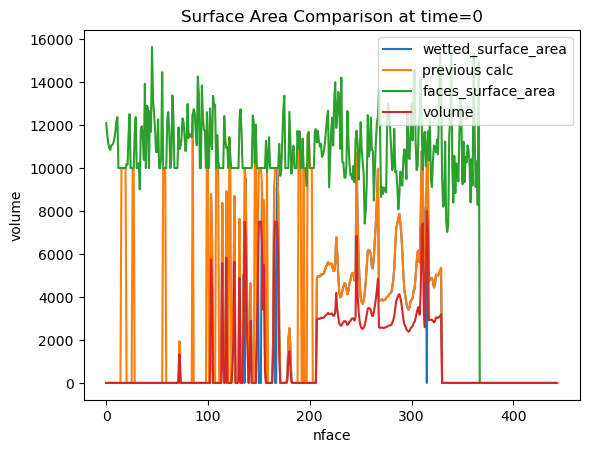

In [ ]:
fig, ax = plt.subplots()

transport_model.mesh.wetted_surface_area.isel(time=t).plot(ax=ax, label='wetted_surface_area')
wetted_sa_subset.wetted_surface_area.isel(time=t).plot(ax=ax, label='previous calc')
transport_model.mesh.faces_surface_area.plot(ax=ax, label='faces_surface_area')
transport_model.mesh.volume.isel(time=t).plot(ax=ax, label = 'volume')

ax.legend()
plt.title(f"Surface Area Comparison at time={t}")
splt.show()

There's a couple places where these don't align... let's check it out.

Set t=-1

In [16]:
t=-1

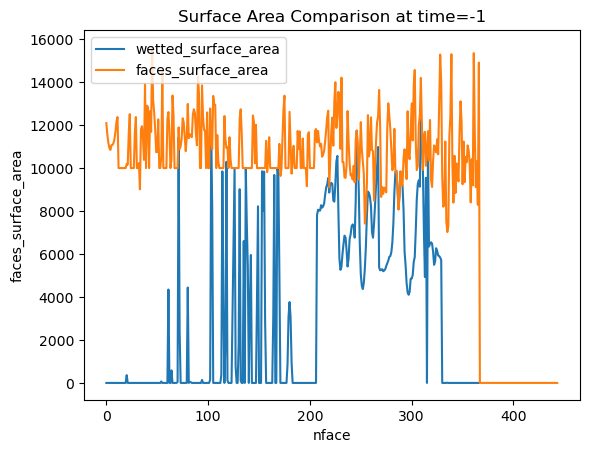

In [40]:
fig, ax = plt.subplots()

transport_model.mesh.wetted_surface_area.isel(time=t).plot(ax=ax, label='wetted_surface_area')
# wetted_sa_subset.wetted_surface_area.isel(time=t).plot(ax=ax, label='previous calc')
# transport_model.mesh.volume.isel(time=t).plot(ax=ax, label = 'volume')
transport_model.mesh.faces_surface_area.plot(ax=ax, label='faces_surface_area')

ax.legend()
plt.title(f"Surface Area Comparison at time={t}")
plt.show()

Check for the difference between the wetted surface area and the total surface area:

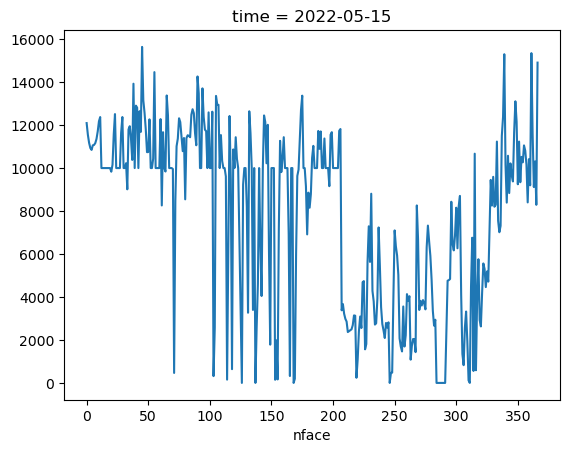

In [41]:
vals = transport_model.mesh.faces_surface_area - transport_model.mesh.wetted_surface_area.isel(time=t)
vals.plot()

Check 1: how often does the difference == 0? I.e, the cell is completely wet?

In [47]:
mask = (vals == 0)

# Use the mask to see where the condition is met
zero_cells = mask.where(mask, drop=False)

wetted_full = np.where(zero_cells == True)[0]

wetted_full


array([126, 137, 168, 246, 284, 285, 286, 287, 288, 289, 290, 291, 311],
      dtype=int64)

This seems pretty aligned with the map. Most cells are partially wet.

Check if there are any cells where the wetted surface area is greater than the total surface area. This would indicate that something bad is happening:

In [ ]:
mask = (vals < 0)
problem_cells = mask.where(mask, drop=False)

problem_full = np.where(problem_cells == True)[0]

problem_full


array([], dtype=int64)

Doesn't look like that is happening!

However, there are some locations where the volume is > 0 but the surface area == 0. Let's check those out.

#### Volume Vs. New Wetted Surface Area

In [50]:
## Where
import numpy as np
# Select the relevant timestep
volume = transport_model.mesh.volume.isel(time=-1)
wetted_sa = transport_model.mesh.wetted_surface_area.isel(time=-1)

# Create mask: volume > 0 and wetted surface area == 0
mask = (volume > 0) & (wetted_sa == 0)

# Use the mask to see where the condition is met
problem_cells = mask.where(mask, drop=False)

problem_indices = np.where(problem_cells == True)[0]

problem_indices

array([136, 150, 151, 152, 166, 167, 315], dtype=int64)

In [51]:
f = 136
t = -1

Now there are some instances where volume is >0 but wetted surface area is = 0. Check it out:

In [52]:
transport_model.mesh.wetted_surface_area.isel(time=t, nface=f).values

array(0.)

In [53]:
transport_model.mesh.faces_surface_area.isel(nface=f).values

array(10000., dtype=float32)

In [54]:
transport_model.mesh.volume.isel(time=t, nface=f).values

array(15394.145, dtype=float32)

In [55]:
lookup_table = transport_model.mesh.attrs['volume_elevation_lookup']

In [56]:
lookup_table[lookup_table.Cell == f]

,Elevation,Volume,Cell,Delta Elev,Delta Volume,Surface Area,Wetted Surface Area,lookup
0,20.0,0.0,136,NaN,NaN,NaN,0.0,0


Looks like I just created the opposite problem for myself. 

Why are there cells that sometimes have a volume but only one entry in their lookup table? Let's look at this cell a little more...

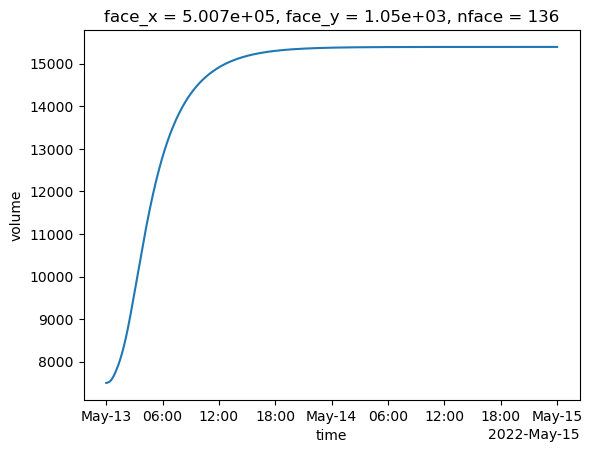

In [58]:
transport_model.mesh.volume.isel(nface=f).plot()

Does this just inidcate flat bythymetry i.e. even if its' just a little volume it's wetted completely?
So if one entry, I need to add another row. 